In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "ZF-HD"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn015051,MEMKGQQGSLGYNNEPIFRETSETLDRHHHLLEQNSPTTTRRPNQD...,262,1
1,Achn041581,MEFDEHEEQEEETGIQVQANYDTAVAGNSGRPKMGGGGEAAALRRG...,233,1
2,Achn074571,MIHHGPAPVPHNHIIVPNLAPQVPSNGSTPTALDLEDHVPYKKMVR...,267,1
3,Achn121961,MKKHQVVVRKNGSNRGVGNSSVASGVRYVECQKNHAANIGGYAVDG...,132,1
4,Achn121971,MSDIKEDAVNKDCSNATSTVQTTNIRYEDCRKNHGARMGKHATDGC...,170,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1936,0.015831,0.002639,0.000000,0.002639,0.000000,0.002639,0.000000,0.00000,0.002639,0.002639,...,0.007916,0.002639,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000
3604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004149,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.004149,0.004149,0.0,0.000000,0.0,0.00000
2988,0.002283,0.002283,0.000000,0.002283,0.000000,0.004566,0.000000,0.00000,0.004566,0.000000,...,0.000000,0.006849,0.0,0.002283,0.002283,0.000000,0.0,0.000000,0.0,0.00000
3442,0.017677,0.000000,0.012626,0.015152,0.002525,0.012626,0.000000,0.00000,0.000000,0.005051,...,0.002525,0.000000,0.0,0.002525,0.000000,0.000000,0.0,0.002525,0.0,0.00000
3952,0.001010,0.000000,0.003030,0.007071,0.001010,0.002020,0.003030,0.00202,0.006061,0.005051,...,0.000000,0.001010,0.0,0.001010,0.004040,0.000000,0.0,0.000000,0.0,0.00202


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4122, 441)
X_test: (1031, 441)
y_train: (4122,)
y_test: (1031,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 32s 637ms/step - accuracy: 0.5156 - loss: 0.6931

28/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6378 - loss: 0.6800   

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7204 - loss: 0.6285 - val_accuracy: 0.9806 - val_loss: 0.0923


Epoch 2/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.1212

29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9737 - loss: 0.0825 

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9731 - loss: 0.0834 - val_accuracy: 0.9867 - val_loss: 0.0504


Epoch 3/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0708

24/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0486 

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0471

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9835 - loss: 0.0470 - val_accuracy: 0.9891 - val_loss: 0.0384


Epoch 4/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0088

26/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0370 

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0360

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9900 - loss: 0.0359 - val_accuracy: 0.9903 - val_loss: 0.0330


Epoch 5/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.1206

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0296 

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0260

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.0257 - val_accuracy: 0.9903 - val_loss: 0.0285


Epoch 6/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0038

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0094 

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0129

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0131 - val_accuracy: 0.9867 - val_loss: 0.0384


Epoch 7/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.5997e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0078     

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0095

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0097 - val_accuracy: 0.9915 - val_loss: 0.0282


Epoch 8/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0024

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0033 

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0053

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.9903 - val_loss: 0.0297


Epoch 9/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0307

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0133 

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0128

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0126 - val_accuracy: 0.9903 - val_loss: 0.0314


Epoch 10/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0027

26/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0075 

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0077

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0077 - val_accuracy: 0.9927 - val_loss: 0.0291


Epoch 11/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0014

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0019 

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0041

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0042 - val_accuracy: 0.9915 - val_loss: 0.0363


Epoch 12/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.6176e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0023     

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0048

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0051 - val_accuracy: 0.9867 - val_loss: 0.0454


Epoch 13/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0027

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0037 

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0038

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9915 - val_loss: 0.0330


Epoch 14/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0012

24/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0013 

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0025

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9891 - val_loss: 0.0316


Epoch 15/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.4939e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.7539e-04 

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0023    

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 0.9903 - val_loss: 0.0347


Epoch 16/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.1352e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0011     

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0034

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.9915 - val_loss: 0.0316


Epoch 17/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.2727e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0050     

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0050

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0049 - val_accuracy: 0.9903 - val_loss: 0.0346


Epoch 18/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.8992e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0033     

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0031

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0031 - val_accuracy: 0.9927 - val_loss: 0.0326


Epoch 19/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.6764e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0066     

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0046

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0045 - val_accuracy: 0.9903 - val_loss: 0.0367


Epoch 20/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.8130e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0014     

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0037

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0038 - val_accuracy: 0.9673 - val_loss: 0.1273



[Train Accuracy: 99.79% - Test Accuracy: 96.41%]

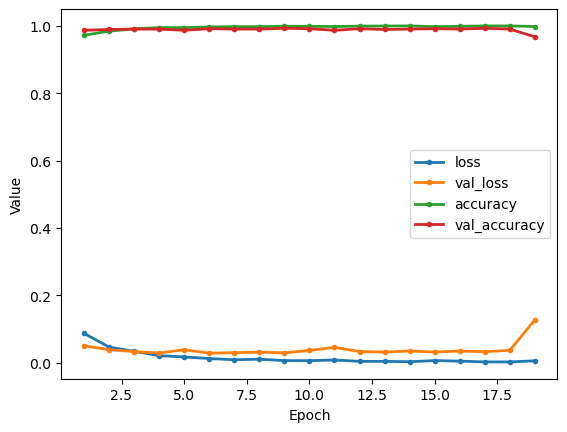

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1936,0.005291,0.0,0.0,0.000000,0.0,0.002646,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3604,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2988,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.002288,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3442,0.007595,0.0,0.0,0.002532,0.0,0.002532,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3952,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.001011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4122, 8734)
X_test: (1031, 8734)
y_train: (4122,)
y_test: (1031,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,236,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,279,425 (8.70 MB)

 Trainable params: 2,279,425 (8.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 33s 651ms/step - accuracy: 0.4688 - loss: 0.6932

 7/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5474 - loss: 0.6930   

14/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5565 - loss: 0.6925

21/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6059 - loss: 0.6909

29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6555 - loss: 0.6866

36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6897 - loss: 0.6794

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7206 - loss: 0.6657

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7422 - loss: 0.6490

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7476 - loss: 0.6439 - val_accuracy: 0.9855 - val_loss: 0.0911


Epoch 2/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.1141

 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9898 - loss: 0.0781 

16/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9893 - loss: 0.0707

24/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9901 - loss: 0.0634

32/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9904 - loss: 0.0577

40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9903 - loss: 0.0546

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9903 - loss: 0.0520

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9904 - loss: 0.0506 - val_accuracy: 0.9964 - val_loss: 0.0197


Epoch 3/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0109

 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0225 

15/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9968 - loss: 0.0183

22/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0157

30/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9973 - loss: 0.0142

38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9975 - loss: 0.0130

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0121

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9977 - loss: 0.0116 - val_accuracy: 0.9988 - val_loss: 0.0140


Epoch 4/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0030

 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023 

15/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020

22/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019

30/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0018

38/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0019

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0020

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9939 - val_loss: 0.0182


Epoch 5/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 9.5830e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011     

15/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010

22/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5888e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9921e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4911e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1009e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7053e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.6625e-04 - val_accuracy: 0.9952 - val_loss: 0.0117


Epoch 6/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.8132e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7959e-04 

16/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9021e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8426e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7489e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6784e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6369e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6480e-04 - val_accuracy: 0.9964 - val_loss: 0.0096


Epoch 7/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0011

 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.6687e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0745e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3241e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9128e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6292e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3652e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1514e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.1278e-04 - val_accuracy: 0.9952 - val_loss: 0.0111


Epoch 8/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.4479e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2225e-04 

16/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3136e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4789e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4990e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4942e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4886e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4816e-04 - val_accuracy: 0.9939 - val_loss: 0.0112


Epoch 9/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.3717e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0758e-04 

17/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1764e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2061e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3010e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3397e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3638e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3659e-04 - val_accuracy: 0.9939 - val_loss: 0.0130


Epoch 10/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.9864e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2542e-04 

17/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9205e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9435e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9006e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8629e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8296e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7923e-04 - val_accuracy: 0.9964 - val_loss: 0.0097


Epoch 11/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.9914e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3260e-05 

15/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9796e-05

23/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6448e-05

31/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4046e-05

39/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3089e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2288e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.1697e-05 - val_accuracy: 0.9952 - val_loss: 0.0109


Epoch 12/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.6625e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4695e-05 

15/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9202e-05

22/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0643e-05

29/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0840e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0798e-05

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0907e-05

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0626e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.0503e-05 - val_accuracy: 0.9939 - val_loss: 0.0129


Epoch 13/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.0452e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3812e-05 

17/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6656e-05

25/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8134e-05

33/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7682e-05

41/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6970e-05

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7116e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8010e-05 - val_accuracy: 0.9939 - val_loss: 0.0138



[Train Accuracy: 100.00% - Test Accuracy: 99.32%]


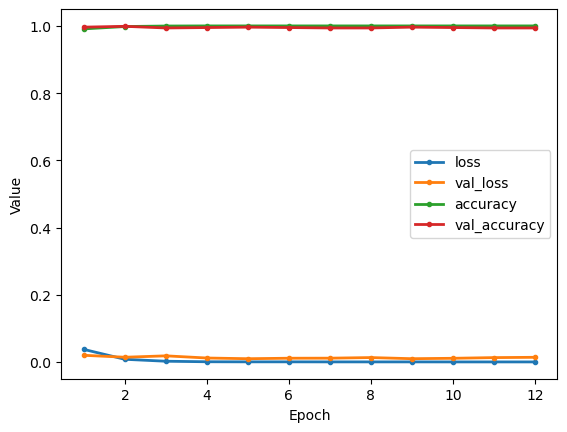

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1936,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3604,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2988,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3442,0.002538,0.0,0.0,0.0,0.0,0.002538,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3952,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,727,873 (136.29 MB)

 Trainable params: 35,727,873 (136.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 43s 856ms/step - accuracy: 0.5156 - loss: 0.6932

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.4883 - loss: 0.6933 

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.4905 - loss: 0.6933

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5046 - loss: 0.6932

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5199 - loss: 0.6931

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5331 - loss: 0.6931

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.5449 - loss: 0.6930

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5520 - loss: 0.6928

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5576 - loss: 0.6927

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.5604 - loss: 0.6926

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.5633 - loss: 0.6924

12/52 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5663 - loss: 0.6922

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5696 - loss: 0.6920

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5737 - loss: 0.6918

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5783 - loss: 0.6916

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5834 - loss: 0.6913

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5889 - loss: 0.6911

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5946 - loss: 0.6908

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.6002 - loss: 0.6905

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.6059 - loss: 0.6902

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6117 - loss: 0.6898

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6171 - loss: 0.6894

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6225 - loss: 0.6890

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.6278 - loss: 0.6886

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.6330 - loss: 0.6881

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.6381 - loss: 0.6876

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.6431 - loss: 0.6871

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.6480 - loss: 0.6865

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6527 - loss: 0.6858

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6573 - loss: 0.6852

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6617 - loss: 0.6844

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6661 - loss: 0.6837

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6703 - loss: 0.6828

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6744 - loss: 0.6819

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6784 - loss: 0.6810

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6822 - loss: 0.6800

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.6860 - loss: 0.6790

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.6897 - loss: 0.6778

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6933 - loss: 0.6766

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6968 - loss: 0.6753

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7003 - loss: 0.6740

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7036 - loss: 0.6726

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7069 - loss: 0.6711

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7100 - loss: 0.6696

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7131 - loss: 0.6679

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7160 - loss: 0.6663

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7190 - loss: 0.6645

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7218 - loss: 0.6627

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7246 - loss: 0.6608

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7273 - loss: 0.6589

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7299 - loss: 0.6568

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7325 - loss: 0.6548

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.7350 - loss: 0.6529 - val_accuracy: 0.9782 - val_loss: 0.1510


Epoch 2/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.9688 - loss: 0.1790

 2/52 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9766 - loss: 0.1638 

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.9792 - loss: 0.1550

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9805 - loss: 0.1481

 5/52 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9806 - loss: 0.1432

 6/52 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9812 - loss: 0.1388

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9817 - loss: 0.1348

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9820 - loss: 0.1312

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9825 - loss: 0.1277

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9828 - loss: 0.1246

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9830 - loss: 0.1218

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9831 - loss: 0.1192

13/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9833 - loss: 0.1166

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9835 - loss: 0.1141

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9838 - loss: 0.1118

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9841 - loss: 0.1095

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9843 - loss: 0.1074

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9845 - loss: 0.1053

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9848 - loss: 0.1033

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9850 - loss: 0.1014

21/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9853 - loss: 0.0996

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9855 - loss: 0.0979

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9857 - loss: 0.0964

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9858 - loss: 0.0949

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9860 - loss: 0.0935

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9862 - loss: 0.0921

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9863 - loss: 0.0908

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9865 - loss: 0.0895

29/52 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9867 - loss: 0.0883

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9868 - loss: 0.0871

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9870 - loss: 0.0860

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9872 - loss: 0.0849

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9873 - loss: 0.0839

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9875 - loss: 0.0828

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9876 - loss: 0.0819

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9877 - loss: 0.0809

37/52 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9878 - loss: 0.0800

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9880 - loss: 0.0791

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9881 - loss: 0.0783

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9882 - loss: 0.0774

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9883 - loss: 0.0766

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9884 - loss: 0.0758

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9885 - loss: 0.0750

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9886 - loss: 0.0743

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9887 - loss: 0.0735

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9888 - loss: 0.0728

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9889 - loss: 0.0721

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9890 - loss: 0.0714

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9891 - loss: 0.0708

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9892 - loss: 0.0701

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9893 - loss: 0.0694

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9894 - loss: 0.0688

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9895 - loss: 0.0682 - val_accuracy: 0.9952 - val_loss: 0.0173


Epoch 3/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 1.0000 - loss: 0.0025

 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0025 

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0034

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0037

 5/52 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0038

 6/52 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0038

 7/52 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0038

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0038

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0037

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0037

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0036

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0036

13/52 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0035

14/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0035

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0035

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0034

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0034

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0034

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0033

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0033

21/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0033

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0032

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0032

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0032

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0031

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0031

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0031

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0030

29/52 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0030

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0030

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 0.0030

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0030

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9999 - loss: 0.0030

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9999 - loss: 0.0030

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9999 - loss: 0.0030

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9999 - loss: 0.0030

37/52 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9999 - loss: 0.0030

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9999 - loss: 0.0030

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9999 - loss: 0.0030

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9999 - loss: 0.0030

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9999 - loss: 0.0030

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9999 - loss: 0.0029

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9999 - loss: 0.0029

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9999 - loss: 0.0029

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9998 - loss: 0.0029

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9998 - loss: 0.0029

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9998 - loss: 0.0029

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9998 - loss: 0.0029

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9998 - loss: 0.0029

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9998 - loss: 0.0029

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9998 - loss: 0.0029

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9998 - loss: 0.0029

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.9998 - loss: 0.0029 - val_accuracy: 0.9976 - val_loss: 0.0141


Epoch 4/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 1.0000 - loss: 9.9482e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 0.0010     

 3/52 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 9.7711e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0010    

 5/52 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 0.0010

 6/52 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 0.0011

 7/52 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0011

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0011

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0011

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0011

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0011

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0012

13/52 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0012

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0012

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0012

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0012

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0012

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0012

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0012

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0012

21/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0012

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0012

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0012

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0011

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0011

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0011

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 0.0011

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 0.0011

29/52 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 0.0011

30/52 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0011

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 0.0011

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 0.0011

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 0.0011

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 0.0011

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 0.0011

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 0.0011

37/52 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 0.0011

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0011

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0011

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0011

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0010

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 0.0010

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0010

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0010

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.0010

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.0010

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.0010

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0010

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0010

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0010

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0010

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 9.9869e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 9.9453e-04 - val_accuracy: 0.9952 - val_loss: 0.0171


Epoch 5/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 1.0000 - loss: 5.0338e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 4.2346e-04

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.9913e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 3.8921e-04

 5/52 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 3.8124e-04

 6/52 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 3.7132e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.6042e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.5396e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.5304e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 3.5202e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.5029e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.5083e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.5175e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 3.5160e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.5085e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.4993e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.4910e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.4905e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.4923e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 3.4962e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 3.4988e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 3.5018e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 3.5038e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.5025e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4994e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4944e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4889e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4846e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 3.4806e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 3.4766e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.4710e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.4664e-04

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.4602e-04

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.4547e-04

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.4484e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.4422e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.4358e-04

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.4293e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.4222e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.4154e-04

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.4090e-04

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.4021e-04

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.3951e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.3874e-04

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.3817e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.3766e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.3711e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.3654e-04

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.3601e-04

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.3544e-04

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.3486e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 3.3428e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 3.3372e-04 - val_accuracy: 0.9927 - val_loss: 0.0191


Epoch 6/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 1.0000 - loss: 4.9281e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 4.0795e-04

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 4.3973e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.3893e-04

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.2985e-04

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.2092e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.1027e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 4.0258e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 4.0137e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.9801e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.9323e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.8812e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.8295e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.7795e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7298e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.7102e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6850e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6588e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6351e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.6090e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.5827e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.5569e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.5300e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.5031e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.4772e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.4513e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.4267e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.4095e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.3916e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.3727e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.3536e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.3343e-04

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.3147e-04

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.2954e-04

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.2761e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.2575e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.2388e-04

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.2214e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.2039e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.1867e-04

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.1696e-04

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.1531e-04

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.1371e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.1214e-04

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.1060e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.0905e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.0753e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.0604e-04

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.0470e-04

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.0335e-04

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.0201e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.0076e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 2.9955e-04 - val_accuracy: 0.9952 - val_loss: 0.0189


Epoch 7/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.0844e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 1.8459e-04

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.8333e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.8617e-04

 5/52 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.8536e-04

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.8533e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.8526e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.8366e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.8555e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.8610e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.8726e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.8778e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.8815e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.8932e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.8985e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.8986e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.8981e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.8952e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.8973e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.8974e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.8996e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.8999e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.8981e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.8951e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.8961e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.8954e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.8927e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.8892e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8850e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8811e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8766e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8720e-04

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8674e-04

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8659e-04

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.8640e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.8616e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8617e-04

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8610e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8632e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8648e-04

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8655e-04

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8658e-04

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8655e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.8649e-04

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8639e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8626e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8610e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8591e-04

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8571e-04

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8551e-04

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8529e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.8507e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.8485e-04 - val_accuracy: 0.9952 - val_loss: 0.0171


Epoch 8/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.0944e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.0382e-04

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 9.5419e-05

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.6325e-05

 5/52 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 9.5469e-05

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 9.5404e-05

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 9.4791e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.6151e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.8597e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.0003e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.0118e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.0215e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.0276e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.0353e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 1.0442e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.0526e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.0588e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.0625e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0649e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0663e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0670e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0666e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0655e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0655e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0652e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0642e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0628e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0624e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.0622e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.0627e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.0630e-04

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.0629e-04

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.0628e-04

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.0633e-04

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.0637e-04

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.0639e-04

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0636e-04

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0631e-04

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0624e-04

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0615e-04

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0609e-04

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0602e-04

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0613e-04

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.0621e-04

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0632e-04

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0639e-04

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0645e-04

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0650e-04

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0652e-04

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0652e-04

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0649e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.0645e-04

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.0642e-04 - val_accuracy: 0.9952 - val_loss: 0.0190


Epoch 9/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 7.3258e-05

 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 7.4215e-05

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.7308e-05

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.5782e-05

 5/52 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 7.5858e-05

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 7.4809e-05

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 7.3436e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 7.2970e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.2558e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.2103e-05

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1630e-05

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 7.1075e-05

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.0702e-05

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.0223e-05

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.9774e-05

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.9423e-05

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.9117e-05

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.8834e-05

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.8867e-05

20/52 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8901e-05

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8882e-05

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8996e-05

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.9303e-05

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.9539e-05

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 6.9802e-05

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 7.0009e-05

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 7.0177e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 7.0304e-05

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 7.0429e-05

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 7.0524e-05

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 7.0680e-05

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 7.0804e-05

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.0887e-05

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.1042e-05

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.1149e-05

36/52 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.1226e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.1298e-05

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.1389e-05

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 7.1507e-05

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.1612e-05

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.1717e-05

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.1811e-05

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.1890e-05

44/52 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.1952e-05

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.2037e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.2104e-05

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.2145e-05

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.2192e-05

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.2222e-05

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.2245e-05

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 7.2251e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.2265e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 7.2278e-05 - val_accuracy: 0.9952 - val_loss: 0.0187


Epoch 10/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 2.3740e-04

 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.0115e-04

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.7744e-04

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.5928e-04

 5/52 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.4600e-04

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.3563e-04

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.2798e-04

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.2197e-04

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.1719e-04

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.1329e-04

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.1187e-04

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.1028e-04

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.0896e-04

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.0773e-04

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0681e-04

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0591e-04

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0520e-04

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0447e-04

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0427e-04

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.0425e-04

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.0407e-04

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.0382e-04

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.0351e-04

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.0309e-04

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0263e-04

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.0214e-04

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.0161e-04

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.0109e-04

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.0060e-04

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.0007e-04

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.9514e-05

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.8965e-05

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.8466e-05

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7998e-05

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7513e-05

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.7042e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.6564e-05

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.6080e-05

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.5592e-05

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.5107e-05

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.4636e-05

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.4169e-05

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.3707e-05

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.3267e-05

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.2825e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.2385e-05

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.1942e-05

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 9.1498e-05

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 9.1212e-05

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.0913e-05

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 9.0620e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 9.0331e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 9.0054e-05 - val_accuracy: 0.9952 - val_loss: 0.0187


Epoch 11/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.4854e-05

 2/52 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 2.6158e-05

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.2940e-05

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.7971e-05

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.0149e-05

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.1437e-05

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2067e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2352e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2788e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 4.2951e-05

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.3277e-05

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.3478e-05

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.3529e-05

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.3431e-05

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3307e-05

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3139e-05

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3020e-05

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.3392e-05

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.3790e-05

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.4087e-05

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.4292e-05

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.4462e-05

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.4744e-05

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.4960e-05

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.5125e-05

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.5243e-05

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.5320e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.5359e-05

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.5403e-05

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.5485e-05

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.5552e-05

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.5587e-05

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.5603e-05

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.5609e-05

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.5625e-05

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.5622e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.5620e-05

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.5625e-05

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.5611e-05

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.5594e-05

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.5584e-05

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.5565e-05

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.5534e-05

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 4.5490e-05

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.5442e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.5385e-05

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.5327e-05

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.5265e-05

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.5203e-05

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.5138e-05

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.5075e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.5010e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 4.4947e-05 - val_accuracy: 0.9952 - val_loss: 0.0201


Epoch 12/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 1.2150e-05

 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.3544e-05

 3/52 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.9955e-05

 4/52 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.2637e-05

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5771e-05

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.9433e-05

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.1598e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.2802e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.3749e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.4487e-05

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.5367e-05

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.6309e-05

13/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.7034e-05

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.7917e-05

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.8798e-05

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.9575e-05

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.0147e-05

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.0601e-05

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.1043e-05

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.1371e-05

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.1679e-05

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.1883e-05

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.2005e-05

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.2098e-05

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.2133e-05

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.2129e-05

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.2091e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 4.2040e-05

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.1992e-05

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.1931e-05

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.1931e-05

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.1905e-05

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.1857e-05

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.1806e-05

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.1771e-05

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 4.1763e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1743e-05

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1719e-05

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1685e-05

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1636e-05

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1584e-05

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1625e-05

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1645e-05

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 4.1741e-05

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.1817e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.1903e-05

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.1975e-05

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.2032e-05

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.2085e-05

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.2131e-05

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 4.2178e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 4.2220e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 4.2261e-05 - val_accuracy: 0.9952 - val_loss: 0.0193


Epoch 13/100


 1/52 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 2.9768e-05

 2/52 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 2.6978e-05

 3/52 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.3132e-05

 4/52 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 3.6543e-05

 5/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.7704e-05

 6/52 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.7975e-05

 7/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.7583e-05

 8/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.7136e-05

 9/52 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.6813e-05

10/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.6539e-05

11/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.6185e-05

12/52 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.5871e-05

13/52 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 3.5486e-05

14/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.5055e-05

15/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.4863e-05

16/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.4648e-05

17/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.4455e-05

18/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.4253e-05

19/52 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.4062e-05

20/52 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.3856e-05

21/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.3953e-05

22/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.3997e-05

23/52 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.3995e-05

24/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.3958e-05

25/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.3912e-05

26/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.3856e-05

27/52 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 3.4188e-05

28/52 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.4477e-05

29/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.4703e-05

30/52 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.4893e-05

31/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.5056e-05

32/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.5200e-05

33/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.5327e-05

34/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.5437e-05

35/52 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.5540e-05

36/52 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.5615e-05

37/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.5669e-05

38/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.5713e-05

39/52 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.5735e-05

40/52 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.5749e-05

41/52 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.5749e-05

42/52 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.5742e-05

43/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.5728e-05

44/52 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 3.5782e-05

45/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.5827e-05

46/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.5927e-05

47/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.6012e-05

48/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.6087e-05

49/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.6158e-05

50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.6230e-05

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.6296e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.6356e-05

52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 3.6415e-05 - val_accuracy: 0.9952 - val_loss: 0.0185



[Train Accuracy: 100.00% - Test Accuracy: 99.22%]


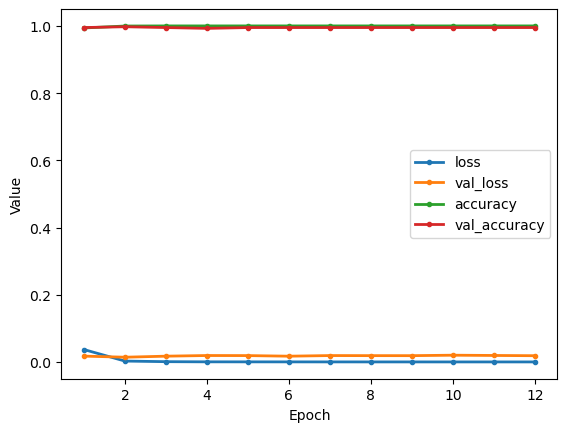

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

 5/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

10/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

 5/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

14/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

19/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/ZF-HD/report_EXQGCVJ1.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################